In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Parameters for sequence length handling
MAX_SEQ_LENGTH = 100  # Set a maximum sequence length
MIN_SEQ_LENGTH = 2  # Optional: Set a minimum sequence length

data_cleaned = pd.read_csv("/Users/jzeng63/Desktop/CDNA/ML/HMM/TS/workplace/Data_processing/Outputs/train_2024_45days_+-_onlyacr.csv")
# Step 1: Create Previous and Current Feature Columns

def create_lag_features(df):
    # Set missing labels to -1
    # df['label'].fillna(-1, inplace=True)

    df = df.dropna().reset_index(drop=True)  # Drop rows with NaN values in lag features
    df['prev_label'] = df['label'].shift(1)
    df["prev_label"].fillna(-1, inplace = True)
    df["past_bx_ady"] = df["ady_dna"].shift(1)
    df["diff"] = df["ady_dna"] - df["past_bx_ady"] # calculate day difference between bx
    df["diff"].fillna(0, inplace = True)
    df = df.dropna(subset = ["usubjid", "ady_dna", 'aval_correct_AlloSure', "prev_label", "diff"]).reset_index(drop=True)
      # Drop rows with NaN values in lag features, e.g. 'prev_label', "diff" !!!!!!!
    return df

# Apply lag feature creation
data_cleaned = data_cleaned.groupby('usubjid', group_keys=False).apply(create_lag_features)

# Step 2: Truncate sequences to the maximum length
truncated_sequences = []
truncated_labels = []

for usubjid, group in data_cleaned.groupby('usubjid'):
    # Truncate based on MAX_SEQ_LENGTH
    if len(group) > MAX_SEQ_LENGTH:
        group = group.iloc[:MAX_SEQ_LENGTH]
    
    # Only include sequences longer than MIN_SEQ_LENGTH
    if len(group) >= MIN_SEQ_LENGTH:
        truncated_sequences.append(group)

# Combine truncated sequences into a DataFrame
data_truncated = pd.concat(truncated_sequences).reset_index(drop=True)

# Step 3: Normalize the features per subject
features_to_normalize = ['aval_AlloMap', 'aval_correct_AlloSure', "ady_dna", "diff"] # ["diff"]

# def normalize_per_subject(df, method='minmax'):
#     if method == 'minmax':
#         scaler = MinMaxScaler()
#     elif method == 'zscore':
#         scaler = StandardScaler()
#     else:
#         raise ValueError("Invalid method. Choose 'minmax' or 'zscore'.")
    
#     # Exclude missing labels (-1) from normalization
#     for feature in features_to_normalize:
#         valid_mask = df[feature] != -1
#         df.loc[valid_mask, feature] = scaler.fit_transform(df.loc[valid_mask, feature].values.reshape(-1, 1))
#     return df

def normalize_per_subject(df, method='minmax'):
    if method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'zscore':
        scaler = StandardScaler()
    else:
        raise ValueError("Invalid method. Choose 'minmax' or 'zscore'.")

    # Normalize all specified features at once
    df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
    return df

# Apply normalization per subject
data_normalized = data_truncated.groupby('usubjid', group_keys=False).apply(normalize_per_subject, method='zscore')

sequence_features = ['aval_AlloMap', 'aval_correct_AlloSure', "prev_label", "diff"] # 'prev_label'!!!!1, "diff" ["prev_label", "diff"]
sequences = []
labels = []
usubjids = []  # Store IDs for each sequence

for usubjid, group in data_normalized.groupby('usubjid'):
    group_data = group[sequence_features].values
    group_labels = group['label'].values
    
    sequences.append(torch.tensor(group_data, dtype=torch.float32))
    labels.append(torch.tensor(group_labels, dtype=torch.float32))
    usubjids.append(usubjid)  # Store the ID

# Step 5: Pad the sequences and labels using -99 as the padding value
padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=-99.0)
padded_labels = pad_sequence(labels, batch_first=True, padding_value=-99.0)

# Create masks
valid_mask = (padded_labels != -1) & (padded_labels != -99)
valid_mask = valid_mask.float()

# Convert usubjids to a numpy array for splitting
usubjids = np.array(usubjids)

# Step 6: Split data into training, validation, and test sets while keeping IDs
train_val_sequences, test_sequences, train_val_labels, test_labels, train_val_mask, test_mask, train_val_ids, test_ids = train_test_split(
    padded_sequences, padded_labels, valid_mask, usubjids, test_size=0.30, random_state=42
)
# train_sequences, val_sequences, train_labels, val_labels, train_mask, val_mask, train_ids, val_ids = train_test_split(
#     train_val_sequences, train_val_labels, train_val_mask, train_val_ids, test_size=0.20, random_state=42
# )



/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_86855/2977058191.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["prev_label"].fillna(-1, inplace = True)
/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_86855/2977058191.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/800, Training Loss: 0.6861912608146667, Validation Loss: 0.6800310015678406
Epoch 2/800, Training Loss: 0.6806029081344604, Validation Loss: 0.6741853356361389
Epoch 3/800, Training Loss: 0.6742116212844849, Validation Loss: 0.6683347821235657
Epoch 4/800, Training Loss: 0.6687936782836914, Validation Loss: 0.6624655723571777
Epoch 5/800, Training Loss: 0.6632765531539917, Validation Loss: 0.6565645337104797
Epoch 6/800, Training Loss: 0.6573628783226013, Validation Loss: 0.6506113409996033
Epoch 7/800, Training Loss: 0.6506335735321045, Validation Loss: 0.6445854306221008
Epoch 8/800, Training Loss: 0.6448894739151001, Validation Loss: 0.6384633779525757
Epoch 9/800, Training Loss: 0.6392843127250671, Validation Loss: 0.6322208046913147
Epoch 10/800, Training Loss: 0.633027970790863, Validation Loss: 0.6258318424224854
Epoch 11/800, Training Loss: 0.6276735663414001, Validation Loss: 0.6192665696144104
Epoch 12/800, Training Loss: 0.6202473640441895, Validation Loss: 0.6124910

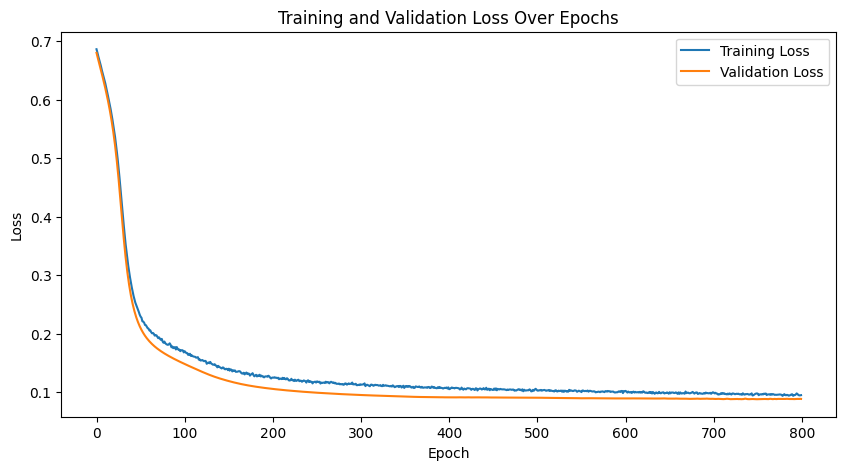

In [2]:
# Step 7: Define the LSTM model (same as before)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.6):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        out = self.fc(lstm_out)
        return out

# Set the parameters for the model
input_size = padded_sequences.shape[2]  # Number of features
hidden_size = 64  # You can adjust this
output_size = 1  # Predicting a single value (current aval_AlloSure)
num_layers = 1 # Number of LSTM layers

# Initialize the model
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

# Step 7: Set up the loss function and optimizer
# criterion = nn.MSELoss(reduction='none')  # Use MSE loss for regression
criterion = nn.BCEWithLogitsLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Step 8: Training loop with validation and loss tracking
train_losses = []
val_losses = []

num_epochs = 800
for epoch in range(num_epochs):
    model.train()
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass on training data
    train_outputs = model(train_val_sequences).squeeze(-1)  # Shape: (batch_size, seq_len)
    
    # Calculate the training loss with mask
    train_loss = criterion(train_outputs, train_val_labels)
    train_loss = train_loss * train_val_mask  # Apply mask to ignore padded positions
    train_loss = train_loss.sum() / train_val_mask.sum()  # Average the loss over non-padded positions
    
    # Backward pass and optimize
    train_loss.backward()
    optimizer.step()
    
    # Store the training loss
    train_losses.append(train_loss.item())
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_sequences).squeeze(-1)
        val_loss = criterion(val_outputs, test_labels)
        val_loss = val_loss * test_mask  # Apply mask to ignore padded positions
        val_loss = val_loss.sum() / test_mask.sum()  # Average the loss over non-padded positions
        
        # Store the validation loss
        val_losses.append(val_loss.item())
    
    # Print losses for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}')

# Step 9: Test set evaluation (after training is complete)
# model.eval()
# with torch.no_grad():
#     test_outputs = model(test_sequences).squeeze(-1)
#     test_loss = criterion(test_outputs, test_labels)
#     test_loss = test_loss * test_mask  # Apply mask to ignore padded positions
#     test_loss = test_loss.sum() / test_mask.sum()  # Average the loss over non-padded positions
#     print(f'Test Loss: {test_loss.item()}')

# Step 10: Plot the Training and Validation Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


# Save model

In [18]:
model_save_path = './Models/lstm_acronly_10102024'
torch.save(model.state_dict(), model_save_path)

In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import pandas as pd
import numpy as np

# Function to evaluate performance on a given dataset
def evaluate_performance(sequences, labels, mask, threshold):
    model.eval()
    with torch.no_grad():
        # Get model outputs (logits) for the dataset
        outputs = model(sequences).squeeze(-1)
        
        # Convert logits to probabilities using sigmoid
        probs = torch.sigmoid(outputs)
        
        # Apply threshold to get binary predictions
        preds = (probs > threshold).float()
        
        # Convert tensors to numpy arrays for scikit-learn compatibility
        labels_np = labels.cpu().numpy()
        probs_np = probs.cpu().numpy()
        preds_np = preds.cpu().numpy()
        
        # Mask to ignore padded positions in the dataset
        mask_np = mask.cpu().numpy()
        valid_indices = mask_np == 1  # Only consider non-padded positions
        
        # Extract valid labels and predictions
        valid_labels = labels_np[valid_indices]
        valid_probs = probs_np[valid_indices]
        valid_preds = preds_np[valid_indices]
        
        # Calculate AUC
        auc = roc_auc_score(valid_labels, valid_probs)

        # Calculate accuracy
        accuracy = accuracy_score(valid_labels, valid_preds)

        # Calculate confusion matrix components for sensitivity, specificity, and PPV
        tn, fp, fn, tp = confusion_matrix(valid_labels, valid_preds).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True positive rate
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True negative rate
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)

        # Return metrics as a dictionary
        return {
            'Threshold': threshold,
            'AUC': auc,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV (Precision)': ppv
        }

# List of thresholds to evaluate
thresholds = np.arange(0.1, 0.6, 0.1)

# Step 1: Evaluate on the full dataset for all thresholds
full_dataset_results = []
for threshold in thresholds:
    result = evaluate_performance(padded_sequences, padded_labels, valid_mask, threshold)
    result['Dataset'] = 'Full Dataset'
    full_dataset_results.append(result)


# Step 2: Evaluate on the test dataset for all thresholds
test_dataset_results = []
for threshold in thresholds:
    result = evaluate_performance(test_sequences, test_labels, test_mask, threshold)
    result['Dataset'] = 'Test Dataset'
    test_dataset_results.append(result)

# Step 3: Create DataFrames to concatenate results
full_dataset_df = pd.DataFrame(full_dataset_results)
test_dataset_df = pd.DataFrame(test_dataset_results)

# Step 4: Concatenate the two DataFrames
combined_df = pd.concat([full_dataset_df, test_dataset_df], ignore_index=True)

# Display the combined results
combined_df.to_csv("./Outputs/lstm_threshold_45days_dropna_init-1_8020_+-_onlyacr.csv")


In [7]:
def evaluate_allosure_performance(data, threshold):
    with torch.no_grad():
        # Extract `aval_AlloSure` values from the sequences
        df_clean = data.loc[(data["label"] != -1) & (data["label"] != -99)]

        valid_allosure = df_clean["aval_correct_AlloSure"]
        valid_labels = df_clean["label"]

        # Apply a threshold to convert `aval_AlloSure` values to binary predictions
        preds = (valid_allosure > threshold).astype(float)

        # Calculate metrics
        auc = roc_auc_score(valid_labels, valid_allosure)
        accuracy = accuracy_score(valid_labels, preds)
        tn, fp, fn, tp = confusion_matrix(valid_labels, preds).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True positive rate
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True negative rate
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)

        # Return metrics as a dictionary
        return {
            'Threshold': threshold,
            'AUC': auc,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV (Precision)': ppv
        }

# List of thresholds to evaluate
thresholds = np.arange(0.1, 0.6, 0.1)

# Step 1: Evaluate on the full dataset for all thresholds
full_dataset_results = []
for threshold in thresholds:
    result = evaluate_allosure_performance(data_truncated,threshold)
    result['Dataset'] = 'Full Dataset'
    full_dataset_results.append(result)

# Step 2: Evaluate on the test dataset for all thresholds
test_dataset_results = []
test_dataset = data_truncated.loc[data_truncated["usubjid"].isin(test_ids)]
for threshold in thresholds:
    result = evaluate_allosure_performance(test_dataset, threshold)
    result['Dataset'] = 'Test Dataset'
    test_dataset_results.append(result)

# Step 3: Create DataFrames to concatenate results
full_dataset_df = pd.DataFrame(full_dataset_results)
test_dataset_df = pd.DataFrame(test_dataset_results)

# Step 4: Concatenate the two DataFrames
combined_df = pd.concat([full_dataset_df, test_dataset_df], ignore_index=True)

combined_df.to_csv("./Outputs/baseline_threshold_45days_dropna_init-1_8020_+-_onlyacr.csv")


# Randomly resample 5 times 

In [20]:
import numpy as np
import pandas as pd
from scipy.stats import iqr

# Function to calculate Q1 and Q3
def q1_q3(data):
    if len(data) > 0:
        return np.percentile(data, 25), np.percentile(data, 75)
    else:
        return np.nan, np.nan

# Function to format the output as 'median (Q1, Q3)'
def format_metric_with_iqr(median_val, q1, q3):
    return f"{median_val:.3f} ({q1:.3f}, {q3:.3f})" if not np.isnan(median_val) else "NaN"

# Function to aggregate and format metrics
def aggregate_metrics_formatted(results_df):
    return results_df.groupby('Threshold').agg(
        AUC_median=('AUC', 'median'),
        AUC_IQR=('AUC', lambda x: q1_q3(x)),
        Accuracy_median=('Accuracy', 'median'),
        Accuracy_IQR=('Accuracy', lambda x: q1_q3(x)),
        Sensitivity_median=('Sensitivity', 'median'),
        Sensitivity_IQR=('Sensitivity', lambda x: q1_q3(x)),
        Specificity_median=('Specificity', 'median'),
        Specificity_IQR=('Specificity', lambda x: q1_q3(x)),
        PPV_median=('PPV (Precision)', 'median'),
        PPV_IQR=('PPV (Precision)', lambda x: q1_q3(x))
    ).apply(lambda row: pd.Series({
        'AUC': format_metric_with_iqr(row['AUC_median'], *row['AUC_IQR']),
        'Accuracy': format_metric_with_iqr(row['Accuracy_median'], *row['Accuracy_IQR']),
        'Sensitivity': format_metric_with_iqr(row['Sensitivity_median'], *row['Sensitivity_IQR']),
        'Specificity': format_metric_with_iqr(row['Specificity_median'], *row['Specificity_IQR']),
        'PPV (Precision)': format_metric_with_iqr(row['PPV_median'], *row['PPV_IQR'])
    }), axis=1)

# Initialize lists to store results for all metrics across splits
model_results_list = []
allosure_results_list = []

# Perform 5 random splits
for i in range(5):
    train_val_sequences, test_sequences, train_val_labels, test_labels, train_val_mask, test_mask, train_val_ids, test_ids = train_test_split(
        padded_sequences, padded_labels, valid_mask, usubjids, test_size=0.30, random_state=i
    )
    
    # Evaluate model performance on the test dataset for all thresholds
    for threshold in thresholds:
        model_result = evaluate_performance(test_sequences, test_labels, test_mask, threshold)
        model_result['Split'] = i
        model_results_list.append(model_result)
    
    # Evaluate AlloSure performance
    test_dataset = data_truncated.loc[data_truncated["usubjid"].isin(test_ids)]
    for threshold in thresholds:
        allosure_result = evaluate_allosure_performance(test_dataset, threshold)
        allosure_result['Split'] = i
        allosure_results_list.append(allosure_result)

# Convert lists of results to DataFrames for easier calculations
model_results_df = pd.DataFrame(model_results_list)
allosure_results_df = pd.DataFrame(allosure_results_list)

# Add a column to indicate the evaluation method
model_results_df['Evaluation Method'] = 'Model'
allosure_results_df['Evaluation Method'] = 'AlloSure'

# Aggregate metrics for both model performance and AlloSure performance
aggregated_model_results = aggregate_metrics_formatted(model_results_df)
aggregated_allosure_results = aggregate_metrics_formatted(allosure_results_df)

### Vertical Concatenation (stack the tables and identify the evaluation method)
# Add a new column 'Source' to each DataFrame to track where the results are coming from
aggregated_model_results['Source'] = 'Model'
aggregated_allosure_results['Source'] = 'AlloSure'

# Concatenate vertically (stacking)
concatenated_results_vertical = pd.concat([aggregated_model_results, aggregated_allosure_results], axis=0)

concatenated_results_vertical.to_csv("./Outputs/acr_confidence_10102024.csv")



# Data Exploration

In [21]:
import pandas as pd

In [28]:
# Step 1: Statistical Summary of ady_dna
data = data_truncated.loc[data_truncated["avisitn"] != 9999]
ady_dna_summary = data[['usubjid', 'ady_dna', "avisitn", "aval_correct_AlloSure", "aval_AlloMap"]].describe()
# print("Statistical Summary of ady_dna:")
print(ady_dna_summary)
ady_dna_summary.to_csv("./Outputs/summary_45days_init-1_+-_acr.csv")

# Label subjects based on whether they ever had a rejection
corrected_label = data.groupby('usubjid')['label'].apply(lambda x: 1 if x.max() == 1 else 0)
data = data.merge(corrected_label.rename('label_usubjid'), on = "usubjid", how = "left")

            ady_dna       avisitn  aval_correct_AlloSure  aval_AlloMap
count  12468.000000  12468.000000           12468.000000  12468.000000
mean     295.906561    298.773340               0.286867     29.791306
std      261.075761    260.060588               0.766376      6.237017
min       16.000000     30.000000               0.110000      2.000000
25%      124.000000    121.000000               0.110000     27.000000
50%      215.000000    182.000000               0.110000     31.000000
75%      357.000000    365.000000               0.143572     34.000000
max     2059.000000   2098.000000              16.100000     39.000000


In [29]:
data['label'].value_counts()

label
0.0    12194
1.0      274
Name: count, dtype: int64

<Axes: >

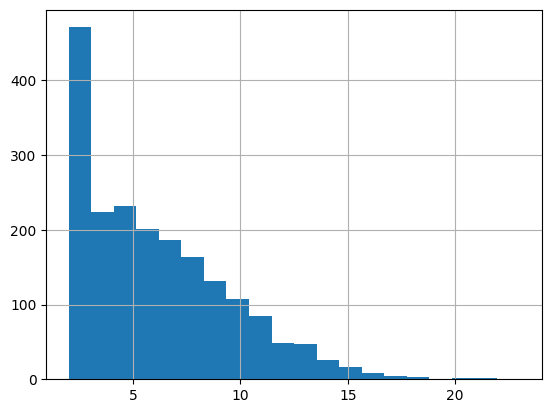

In [30]:
data['usubjid'].value_counts().hist(bins = 20)

In [31]:
data.drop_duplicates("usubjid")['label_usubjid'].value_counts()

label_usubjid
0    1771
1     191
Name: count, dtype: int64

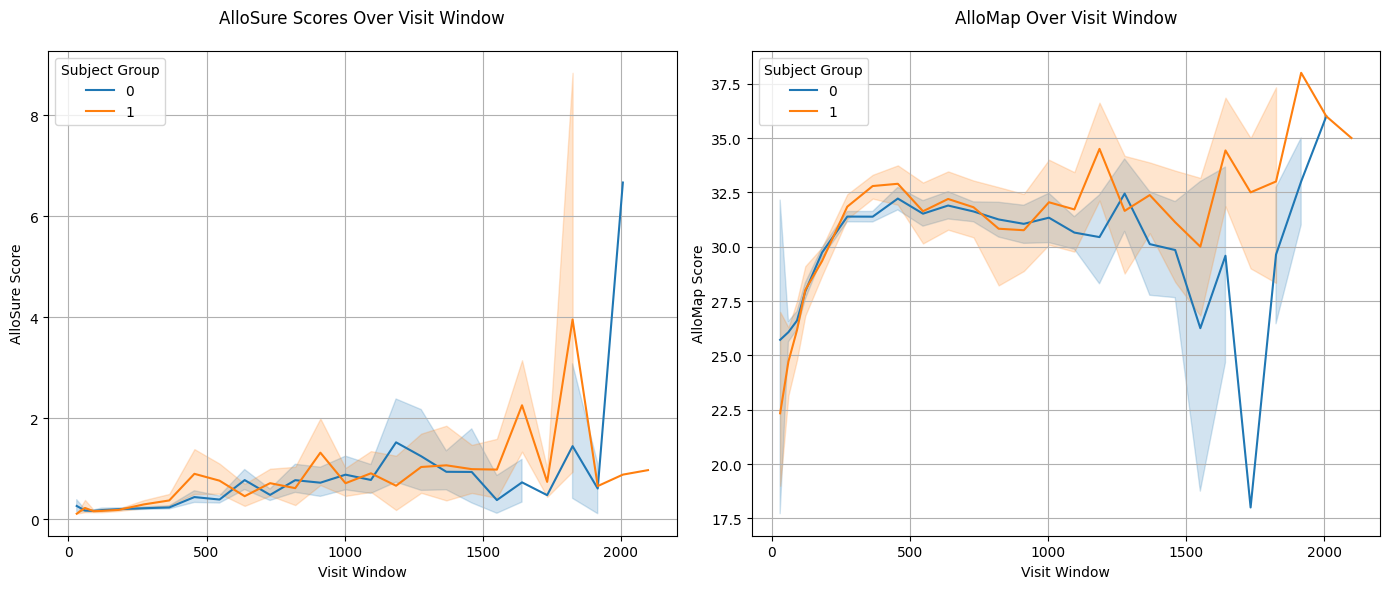

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Smoothed plot for globally binned normalized AlloSure over time for the two groups
plt.subplot(1, 2, 1)
sns.lineplot(x='avisitn', y='aval_correct_AlloSure', hue='label_usubjid', data=data)
plt.title('AlloSure Scores Over Visit Window', pad=20)
plt.xlabel('Visit Window')
plt.ylabel('AlloSure Score')
plt.legend(title='Subject Group')
plt.grid(True)

# Smoothed plot for globally binned normalized AlloMap over time for the two groups
plt.subplot(1, 2, 2)
sns.lineplot(x='avisitn', y='aval_AlloMap', hue='label_usubjid', data=data)
plt.title('AlloMap Over Visit Window', pad=20)
plt.xlabel('Visit Window')
plt.ylabel('AlloMap Score')
plt.legend(title='Subject Group')
plt.grid(True)

plt.tight_layout()
plt.show()

# Logistic Regression Model

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd

# --- Rebuild the datasets based on IDs ---
data_truncated_dropna = data_truncated.dropna(subset = ["usubjid", 'aval_AlloMap', 'aval_correct_AlloSure', "label"])
# Assuming `data_truncated` contains the original dataset
train_data = data_truncated_dropna.loc[data_truncated_dropna["usubjid"].isin(train_val_ids)]
test_data = data_truncated_dropna.loc[data_truncated_dropna["usubjid"].isin(test_ids)]

# # Further split train_val_data into training and validation sets
# train_data = train_val_data.loc[train_val_data["usubjid"].isin(train_ids)]
# val_data = train_val_data.loc[train_val_data["usubjid"].isin(val_ids)]

# Extract features and labels for each set
def extract_features_and_labels(data):
    features = data[['aval_AlloMap', 'aval_correct_AlloSure']].values
    labels = data['label'].values
    return features, labels

train_features, train_labels = extract_features_and_labels(train_data)
# val_features, val_labels = extract_features_and_labels(val_data)
test_features, test_labels = extract_features_and_labels(test_data)

# --- Normalize Features ---

# Standardize the features using StandardScaler
# scaler = StandardScaler()
# train_features = scaler.fit_transform(train_features)
# val_features = scaler.transform(val_features)
# test_features = scaler.transform(test_features)

# --- Train Logistic Regression Model ---

# Define logistic regression model with grid search
logistic_model = LogisticRegression(max_iter=1000, solver='saga')  # 'saga' solver supports 'elasticnet'
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization types
    'l1_ratio': [0.1, 0.5, 0.9]  # Only used when penalty='elasticnet'
}

# Fit the model using GridSearchCV
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(train_features, train_labels)

# Use the best model for evaluation
best_model = grid_search.best_estimator_

# --- Evaluation Section ---

# Function to evaluate performance
def evaluate_performance(features, labels, threshold):
    # Get model outputs (probabilities) for the dataset
    probs = best_model.predict_proba(features)[:, 1]  # Probability of the positive class

    # Apply threshold to get binary predictions
    preds = (probs > threshold).astype(float)

    # Calculate AUC
    auc = roc_auc_score(labels, probs)

    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

    # Calculate confusion matrix components for sensitivity, specificity, and PPV
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True positive rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True negative rate
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)

    # Return metrics as a dictionary
    return {
        'Threshold': threshold,
        'AUC': auc,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'PPV (Precision)': ppv
    }

# List of thresholds to evaluate
thresholds = np.arange(0.1, 0.6, 0.1)

# Evaluate on the full dataset (training + validation + test)
full_features = np.concatenate([train_features, test_features])
full_labels = np.concatenate([train_labels, test_labels])
full_results = []
for threshold in thresholds:
    result = evaluate_performance(full_features, full_labels, threshold)
    result['Dataset'] = 'Full Dataset'
    full_results.append(result)

# Evaluate on the test dataset
test_results = []
for threshold in thresholds:
    result = evaluate_performance(test_features, test_labels, threshold)
    result['Dataset'] = 'Test Dataset'
    test_results.append(result)

# Create DataFrames to concatenate results
full_df = pd.DataFrame(full_results)
test_df = pd.DataFrame(test_results)

# Concatenate the results and display
combined_df = pd.concat([full_df, test_df], ignore_index=True)
print(combined_df)

# Optionally save to CSV
combined_df.to_csv("./Outputs/logistic_threshold_evaluation_45days_dropna_init-1_8020_+-_noprevisBX_acronly.csv", index=False)


Fitting 5 folds for each of 45 candidates, totalling 225 fits


/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is

   Threshold       AUC  Accuracy  Sensitivity  Specificity  PPV (Precision)  \
0        0.1  0.630949  0.975868     0.014599     0.997459         0.114286   
1        0.2  0.630949  0.977311     0.003650     0.999180         0.090909   
2        0.3  0.630949  0.977872     0.003650     0.999754         0.250000   
3        0.4  0.630949  0.977872     0.003650     0.999754         0.250000   
4        0.5  0.630949  0.977952     0.000000     0.999918         0.000000   
5        0.1  0.639152  0.976314     0.012346     0.998051         0.125000   
6        0.2  0.639152  0.977403     0.012346     0.999165         0.250000   
7        0.3  0.639152  0.978219     0.012346     1.000000         1.000000   
8        0.4  0.639152  0.978219     0.012346     1.000000         1.000000   
9        0.5  0.639152  0.977947     0.000000     1.000000         0.000000   

        Dataset  
0  Full Dataset  
1  Full Dataset  
2  Full Dataset  
3  Full Dataset  
4  Full Dataset  
5  Test Dataset  
6  T

# Inference of model

In [34]:
# Define the path where the model was saved
model_save_path = './Models/lstm_acronly_10102024'

# Initialize the model with the same architecture
loaded_model = LSTMModel(input_size, hidden_size, output_size, num_layers)

# Load the saved model parameters (state dictionary)
loaded_model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode
loaded_model.eval()

print("Model loaded successfully.")

Model loaded successfully.


/Users/jzeng63/opt/miniconda3/envs/TS/lib/python3.9/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/var/folders/fq/2bbp_3150570hsrlsnv31c_m0000gn/T/ipykernel_86855/1243142187.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are exp

In [39]:
train_val_sequences, test_sequences, train_val_labels, test_labels, train_val_mask, test_mask, train_val_ids, test_ids = train_test_split(
    padded_sequences, padded_labels, valid_mask, usubjids, test_size=0.30, random_state=i
)
# List of thresholds to evaluate
thresholds = np.arange(0.1, 0.6, 0.1)

# Step 1: Evaluate on the full dataset for all thresholds
full_dataset_results = []
for threshold in thresholds:
    result = evaluate_performance(padded_sequences, padded_labels, valid_mask, threshold)
    result['Dataset'] = 'Full Dataset'
    full_dataset_results.append(result)


# Step 2: Evaluate on the test dataset for all thresholds
test_dataset_results = []
for threshold in thresholds:
    result = evaluate_performance(test_sequences, test_labels, test_mask, threshold)
    result['Dataset'] = 'Test Dataset'
    test_dataset_results.append(result)